# Simulating fly-bys

This notebook will take you through a simulation of fly-bys of a star perturbing a planetary system.

### Imports

In [10]:
import rebound
import numpy as np

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

### Setup
Let's first create a simulation of our target planetary system. We'll use Sun and the outer planets of our solar system for now. Using NASA Horizons database to get the details of each object.

In [2]:
sim = rebound.Simulation()
particle_names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"]
# we use the NASA horizon database to look up the Sun and planets
sim.add(particle_names)

# let's give all the particles a unique hash (based on its name)
for i, particle in enumerate(sim.particles):
    particle.hash = particle_names[i]

sim.status()
    

Searching NASA Horizons for 'Sun'... 

KeyboardInterrupt: 

Let's save this simulation for future reference.

In [6]:
sim.save("solar_system_outer_planets.bin")

In [2]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")

Let's define a function that simulates a single fly-by given a certain system and a particle that will be intruding the system.

In [57]:
def simulate_fly_by(sim, intruder, visualize=False):
    
    intruder.hash = "intruder"
    sim.add(intruder)
    
    intruder_distance = np.linalg.norm(sim.particles["intruder"].xyz)
    sim.exit_max_distance = intruder_distance*1.01
    
    while True:
        try:
            sim.integrate(sim.t+50)
            
            if visualize:
                fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
                display(fig)
                plt.close(fig)
                clear_output(wait=True)

        except rebound.Escape as error:
            if type(rebound.Escape()) == type(error):
                print("joe")
            # remove intruder
            sim.remove(hash="intruder")
            sim.move_to_com()
                    
            return sim


In [58]:
def evolve_system(sim, t):
    sim.exit_max_distance = 500
    
    close_encounters = []
    ejections = []
    # set planet radii to their hill spheres
    for planet in sim.particles[1:]:
        planet.r = hill_radius(planet, sim.particles[0])
        
    sim.collision = "direct"
    
    end_time = sim.t + t
    while sim.t < end_time:
        try:
            sim.integrate(end_time)
        except (rebound.Collision, rebound.Escape) as error:
            sim.status()
            if type(error) == type(rebound.Collision()):
                print(error, sim.t)
                collided = []
                for particle in sim.particles:
                    if particle.lastcollision == sim.t:
                        collided.append(particle.index)
                
                planet_1 = sim.particles[collided[0]]
                planet_2 = sim.particles[collided[1]]
                
                d = np.linalg.norm(np.array(planet_1.xyz) - np.array(planet_2.xyz))
                print(planet_1.index, planet_2.index, "close encounter. distance:", d)
            
                resolve_collision(sim)
                close_encounters.append(((planet_1.index, planet_2.index), d, sim.t))
            
            else:
                print(error)
                out_of_bounds = []
                for i, particle in enumerate(sim.particles):
                    distance = np.linalg.norm(particle.xyz)
                    if distance > sim.exit_max_distance:
                        print("Removed", particle.index, str(particle.hash))
                        out_of_bounds.append(particle.hash)
                        ejections.append((particle.index, particle.xyz, sim.t))
                
                for hsh in out_of_bounds:
                        sim.remove(hash=hsh)
                        sim.move_to_com()
                        
    return (sim, close_encounters, ejections)
    

In [59]:
def resolve_collision(sim):
    while True:
        try:
            sim.integrate(sim.t+0.1)
            return
        except:
            #  integrate one step without collision detection
            sim.collision = "none"
            sim.step()
            sim.collision = "direct"
            

In [8]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.0,x=30.6,y=-1000.,vy=2.)
sim = simulate_fly_by(sim, intruder)

evolve_system(sim, 10**7)

joe


In [29]:
sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_5788.bin")
for particle in sim.particles:
    print(particle.hash)
    
sim.status()

c_uint(3000342645)
c_uint(3586273463)
c_uint(4066125545)
c_uint(516400076)
c_uint(1470785325)
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	2.9558356028911448e+05
Current timestep:    	1.791724
---------------------------------
<rebound.Particle object, m=1.0 x=0.790392015242414 y=1.2800362480961802 z=0.010029648972591659 vx=-0.00042033941518836116 vy=0.000129634499445474 vz=1.1512510585973728e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.62321457248114 y=-3.5400958261243316 z=0.07831235094641473 vx=0.37710694334404987 vy=-0.19041810608900203 vz=-0.008487860358737817>
<rebound.Particle object, m=0.0002858856727222417 x=7.393583393592568 y=-6.584560782884102 z=-0.07737077919291399 vx=0.22619076558664736 vy=0.1970974490642162 vz=-0.012280195894553527>
<rebound.Particle object, m=4.36624373583127e-05 x=20.285578703970426 y=5.068961369614927 z=-

In [60]:
total_simulations = 200
max_evolve_time = 10**5
a_list = np.linspace(0, 100, total_simulations)

results = []

close_encounter_times = []
ejection_times = []

for sim_n in range(total_simulations):
    print(sim_n)
    random_sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_{:04d}.bin".format(np.random.randint(0,10**4)))
    random_sim.t = 0
    intruder = rebound.Particle(m=1.0, x=a_list[sim_n], y=-1000., vy=2.)
    
    sim = simulate_fly_by(random_sim, intruder, visualize=True)
    result = evolve_system(sim, max_evolve_time)
    sim, close_encounters, ejections = result
    
    results.append(result)
    
    if close_encounters:
        close_encounter_times.append(close_encounters[0][-1])
        
    if ejection_times:
        ejection_times.append(ejections[0][-1])
        
close_encounter_times.sort()   
fraction_encounters = np.arange(1, len(close_encounter_times) + 1) / total_simulations

ejection_times.sort()
fraction_ejections = np.arange(1, len(ejection_times) + 1) / total_simulations
    
    

joe


AttributeError: module 'numpy' has no attribute 'arrange'

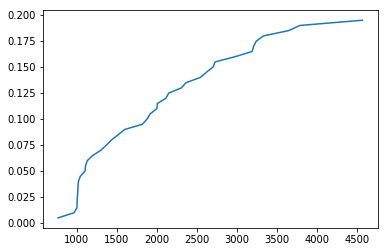

In [74]:
first_ejections_times = []
for result in results:
    if result[2]:
        first_ejections_times.append(result[2][0][-1])

first_ejections_times.sort()
fraction_ejections = np.arange(1, len(first_ejections_times) + 1) / len(results)

plt.plot(first_ejections_times, fraction_ejections)
    
    
    
    
    
    

In [12]:
def hill_radius(planet, star):
    return planet.a * (1 - planet.e) * np.cbrt(planet.m / (3. * star.m))

In [17]:
def calc_mutual_hill_radii_matrix(sim):
    host_star = sim.particles[0]
    
    hill_radii = np.zeros((len(sim.particles[1:]), len(sim.particles[1:])))

    # find largest mutual hill radius in sim
    for i, planet_1 in enumerate(sim.particles[1:]):
        for j, planet_2 in enumerate(sim.particles[i+2:]):
            j = j + i + 1
            print(i,j)
            mutual_hill_radius = calc_mutual_hill_radius(planet_1, planet_2, host_star.m)
            hill_radii[i][j] = mutual_hill_radius
            hill_radii[j][i] = mutual_hill_radius
    
    return hill_radii

# TEST
calc_mutual_hill_radii_matrix(sim)
    

0 1
0 2
0 3
1 2
1 3
2 3


array([[0.        , 0.54933768, 0.84528148, 1.22556907],
       [0.54933768, 0.        , 0.6881079 , 0.95618489],
       [0.84528148, 0.6881079 , 0.        , 0.77981562],
       [1.22556907, 0.95618489, 0.77981562, 0.        ]])

In [3]:
def calc_mutual_hill_radius(p1, p2, m_host):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    mutual_hill_radius = (p1.a + p2.a) / 2. * np.cbrt((p1.m + p2.m) / (3. * m_host))
    return mutual_hill_radius
    

In [23]:
def calc_escape_velocity(sim, particle):
    #sim.move_to_hel()
    
    r = np.linalg.norm(particle.xyz)
    G = sim.G
    m = sim.particles[0].m
    
    return np.sqrt(2 * G * m / r)

In [37]:
def strong_regime(resolution=100, n_trials=50):
    print("Starting strong regime simulation with resolution {}, {} trials each...".format(resolution, n_trials))
    xs = np.linspace(1, 50, resolution)
    f_eject = np.ones(resolution)
    
    for i, x in enumerate(xs):
        print("Running r_min =", x)
        eject_count = 0.
        
        # run n_trials trials detecting ejection directly after fly-by
        for j in range(n_trials):
            # get a fresh simulation
            sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
            sim = randomize_sim(sim)
            
            intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
            
            sim = simulate_fly_by(sim, intruder)
            
            sim.move_to_hel()
            for particle in sim.particles:
                v = np.linalg.norm(particle.vxyz)
                v_esc = calc_escape_velocity(sim, particle)
                if v > v_esc:
                    eject_count += 1
                    break
        print("Detected", eject_count, "ejections out of", n_trials, "trials.")
        f_eject[i] = eject_count / n_trials
        print(f_eject[i])

    
    return (xs, f_eject)            

Let's define a function to predict the stabillity of a system directly after a fly-by.

Instabillity can be defined in a number of ways. The simplest being direct ejection from the system.

This function will try to analyze the stability of a system based on direct observations of it's orbits properties.

In [25]:
def analyze_stability(sim):
    """Check stabillity of an orbit return True if (possibly) stable, False if unstable"""
    
    if check_immediate_ejection(sim) == True:
        return False
    
    elif check_orbit_crossing(sim) == True:
        return False
    
    elif check_kozai(sim) == True:
        return False
    
    elif check_AMD(sim) == True:
        return False
    
    else:
        return True
    

In [26]:
def check_immediate_ejection(sim):
    # move to Sun frame
    sim.move_to_hel()
    
    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            return True
    
    return False
    


In [19]:
sim = rebound.Simulation()
sim.add(m=1.)


In [27]:
def check_kozai(sim):
    # compare all particles
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True
    
    return False
            

Starting strong regime simulation with resolution 30, 100 trials each...
Running r_min = 1.0


/home/simon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Detected 100.0 ejections out of 100 trials.
1.0
Running r_min = 2.689655172413793
Detected 100.0 ejections out of 100 trials.
1.0
Running r_min = 4.379310344827586
Detected 94.0 ejections out of 100 trials.
0.94
Running r_min = 6.068965517241379
Detected 82.0 ejections out of 100 trials.
0.82
Running r_min = 7.758620689655173
Detected 83.0 ejections out of 100 trials.
0.83
Running r_min = 9.448275862068966
Detected 69.0 ejections out of 100 trials.
0.69
Running r_min = 11.137931034482758
Detected 67.0 ejections out of 100 trials.
0.67
Running r_min = 12.827586206896552
Detected 49.0 ejections out of 100 trials.
0.49
Running r_min = 14.517241379310345
Detected 50.0 ejections out of 100 trials.
0.5
Running r_min = 16.20689655172414
Detected 44.0 ejections out of 100 trials.
0.44
Running r_min = 17.896551724137932
Detected 32.0 ejections out of 100 trials.
0.32
Running r_min = 19.586206896551726
Detected 35.0 ejections out of 100 trials.
0.35
Running r_min = 21.275862068965516
Detected 32

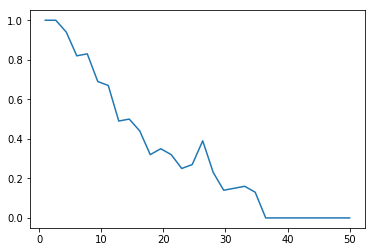

In [30]:
xs, f_eject = strong_regime(resolution=30, n_trials=100)

plt.plot(xs, f_eject)

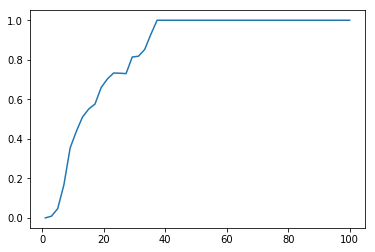

In [50]:
plt.plot(xs, 1-f_eject)

In [32]:
a = np.ones(10)
a[2] = 5
a


array([1., 1., 5., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
def randomize_sim(sim):
    sim.integrate(np.random.random()*10**3)
    return sim
    

In [60]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
simulate_fly_by(sim, intruder, visualize=True)

In [13]:
sim.particles[4].inc

0.030897078503559147